# SMASAC - Data Collection

This notebook shows how to use the [Twitter API](https://developer.twitter.com/en/docs) for collecting data on twitter. We show how to use the [Tweepy library](http://tweepy.readthedocs.io/en/v3.6.0/) for collecting data, how to restrict search results and perform some basic visualisation and filtering of the collected data. This notebook is structured as follow:

1. OAuth and Tweepy configuration
2. Obtaining some data using the seach API
3. Using the streaming API
4. Clustering and Filtering

In [ ]:
# Load .env file if it exists:
%load_ext dotenv
%dotenv api.env

# Import required libraries:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import requests
import folium
import os
import tweepy
import uuid
import json
import pandas as pd
import numpy as np
from geopandas import GeoDataFrame
from shapely.geometry import Point

## OAuth and Tweepy Configuration

Twitter and other social media platforms use a form of authentication called 'OAuth'. There are different types of authentification. In order to colect data, you need a Twitter account and generate four different access token (see [the API key generation tutorial](http://social-metrics.org/api-keys/)):

In [2]:
# Add your personal tokens below:
CONSUMER_KEY    = '<YOUR_CONSUMER_KEY>'
CONSUMER_SECRET = '<YOUR_CONSUMER_SECRET>'
ACCESS_TOKEN    = '<YOUR_ACCESS_TOKEN>'
TOKEN_SECRET    = '<YOUR_TOKEN_SECRET>'

# Load environment variables instead if they exists:
CONSUMER_KEY = os.environ.get('CONSUMER_KEY', CONSUMER_KEY)
CONSUMER_SECRET = os.environ.get('CONSUMER_SECRET', CONSUMER_SECRET)
ACCESS_TOKEN = os.environ.get('ACCESS_TOKEN', ACCESS_TOKEN)
TOKEN_SECRET = os.environ.get('TOKEN_SECRET', TOKEN_SECRET)

In [3]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, TOKEN_SECRET)
api = tweepy.API(auth)

## Getting Some Data with the Search API
First we obtain some data using the basic Twitter seach API. Tweepy manages rate limits and other APIs limitations.
In order to find relevant tweets, we can use query parameters such as keywords or geolocation.


In [4]:
# Set some simple earthquake related keywords: 
keywords = ['earthquake', 'quake', 'magnitude', 'epicenter', 'magnitude', 'aftershock']

# Collect 100 tweets using the keywords:
search_results = api.search(q=' OR '.join(keywords), count=100)

Each Twitter message is encoded a JSON and contains multiple information besides its author and text:

In [5]:
if search_results is not []:
    # Print the first Tweet as JSON:
    print(json.dumps(search_results[0]._json, indent=2))

{
  "place": null,
  "created_at": "Wed Apr 18 15:40:43 +0000 2018",
  "coordinates": null,
  "retweet_count": 1,
  "in_reply_to_status_id": null,
  "in_reply_to_user_id": null,
  "user": {
    "name": "NBC Bay Area",
    "profile_use_background_image": true,
    "friends_count": 1290,
    "notifications": false,
    "profile_background_color": "0082C8",
    "profile_background_image_url_https": "https://pbs.twimg.com/profile_background_images/723861891/b314019172979d99ed50f5d45be491b5.jpeg",
    "follow_request_sent": false,
    "profile_background_tile": false,
    "url": "https://t.co/GItaIcePJK",
    "location": "San Francisco Bay Area",
    "lang": "en",
    "protected": false,
    "followers_count": 313649,
    "id": 20097362,
    "is_translation_enabled": false,
    "time_zone": "Pacific Time (US & Canada)",
    "profile_link_color": "0099B9",
    "is_translator": false,
    "profile_text_color": "3C3940",
    "verified": true,
    "description": "Thank you for stopping by @NBCB

We can convert the data into a dataframe for simpliufying its manipulation as well as exporting it to CSV for further processing:

In [6]:
df = pd.DataFrame([ {'id': result.id, 'created_at': result.created_at, 'user': '@'+result.user.name, 'text': result.text } for result in  search_results])[['id', 'created_at', 'user', 'text']]
display(df)

,id,created_at,user,text
0,986630613875617792,2018-04-18 15:40:43,@NBC Bay Area,RT @KrisNBC: Look at the legend for this simul...
1,986630613041020929,2018-04-18 15:40:43,@Mónica Salas Paz,RT @InfoSismos: #Sismo sentido en Córdoba y Sa...
2,986630587178999808,2018-04-18 15:40:37,@EARTHQUAKE TRACKER,"M ? - 7km NW of The Geysers, CA https://t.co/b..."
3,986630585845190657,2018-04-18 15:40:37,@EARTHQUAKE TRACKER,"M 1.0 - 61km NW of Cape Yakataga, Alaska https..."
4,986630584414982149,2018-04-18 15:40:36,@EARTHQUAKE TRACKER,"M 0.6 - 6km NW of The Geysers, CA https://t.co..."
5,986630583076999168,2018-04-18 15:40:36,@EARTHQUAKE TRACKER,"M 1.1 - 28km NNE of Kernville, CA https://t.co..."
6,986630581936119813,2018-04-18 15:40:36,@EARTHQUAKE TRACKER,"M 1.0 - 61km NW of Cape Yakataga, Alaska https..."
7,986630581281837057,2018-04-18 15:40:35,@ATENTI,RT @ChileAlertaApp: New #Earthquake. 🌎\n4.5 - ...
8,986630577053945857,2018-04-18 15:40:34,@Fredymirandal,RT @ChileAlertaApp: Actualización de informe s...
9,986630527980654593,2018-04-18 15:40:23,@#BastaDeLiberarChorros,RT @ChileAlertaApp: New #Earthquake. 🌎\n4.5 - ...


Bezsides using keywords, we can also restrict the results within a particular location and given language:

In [35]:
# What is the weather 500mm around Lyon?: 
keywords2 = ['weather' , 'forcast', 'sun', 'rain', 'clouds', 'storm']

# Only in english please !
lang = 'en'

# Get tweets around Lyon (latitide,longitude,radius):
geocode = '45.76,4.84,500km'

# Collect 1500 tweets using the keywords:
search_results2 = api.search(q=' OR '.join(keywords2), geocode=geocode, lang=lang, count=1500)


# Convert to GeoPandas:
df2 = pd.DataFrame([ {'id': result.id, 'created_at': result.created_at, 'user': '@'+result.user.name, 'text': result.text, 'geometry': result.coordinates } for result in  search_results2])[['id', 'created_at', 'user', 'text', 'geometry']]
df2['geometry'] = df2['geometry'].apply(lambda coords: np.nan if coords is None else Point(coords['coordinates']))
df2 = df2.dropna() # Remove documents without geometry point (the twitter API may obtain location using user details rather than the tweet location.).
df2 = GeoDataFrame(df2, crs = {'init': 'epsg:2263'})

display(df2)

,id,created_at,user,text,geometry
25,986628016003600389,2018-04-18 15:30:24,@MeteoMignanego,"Wind 16,0 km/h NNW. Barometer 1023,74 hPa, Fal...",POINT (9.52 44.86694444)
45,986626244505751552,2018-04-18 15:23:21,@David Avril,Rest day ☀️\n#nature #sun #summer #beach #beau...,POINT (2.31667 48.75)
68,986622891398746112,2018-04-18 15:10:02,@Chefonabike®,Needed to feel the Sun and smell the pine tree...,POINT (6.86667 45.9167)


We can now display the tweets on a map in order to see the weather around Lyon.
We can also do some basic keyword matching to display icons representing the weather:

In [36]:
# Create a map:
results2_map = folium.Map([45.76,4.84],
                  zoom_start=6,
                  tiles='Stamen Toner')

# Iterate over documents and add them the amp:
for index, document in tqdm_notebook(df2.iterrows()):
    
    # Perform very simple matching of words for displaying the weather:
    if 'sun' in document['text'].lower() or 'clear' in document['text'].lower():
        icon_img = 'sun-o'
        color = 'orange'
        
    elif 'rain' in document['text'].lower() or 'showers' in document['text'].lower():
        icon_img = 'umbrella'
        color = 'blue'
        
    elif 'strom' in document['text'].lower():
        icon_img = 'bolt'
        color = 'black'
    
    elif 'cloud' in document['text'].lower():
        icon_img = 'cloud'
        color = 'gray'
        
    else:
        icon_img = 'info-circle'
        color = 'green'
    
    icon = folium.Icon(color=color, icon_color='white', icon=icon_img, angle=0, prefix='fa')
    folium.Marker([document['geometry'].y, document['geometry'].x], popup=document['text'], icon=icon).add_to(results2_map)

display(results2_map)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

## Streaming API
In order to obtain data in realtime as new data is produced, it is necessary to use the Twitter streaming API. In this section we show how to collect tweets using the streaming API.

The first step is to create a listener that will colect the tweet and store them. In a real pipeline the tweet may be passed to another process as they are collected rather than stored.

In [10]:
# Create listener:
class TwitterStreamListener(tweepy.StreamListener):
    
    def __init__(self, api=None, max_count=1000):
        super(TwitterStreamListener, self).__init__(api)
        
        self.max_count = max_count
        self.count = 0
        self._data = []
        
        if self.max_count is not None:
            self._pbar = tqdm_notebook(total=self.max_count, desc='Collecting tweets.')
            self._pbar.clear()
      
    # Retrun the data as a dataframe:
    @property
    def data(self):
        results = self._data
        df = pd.DataFrame([ {'id': result.id, 'created_at': result.created_at, 'user': '@'+result.user.name, 'text': result.text, 'geometry': result.coordinates } for result in  results])[['id', 'created_at', 'user', 'text', 'geometry']]
        df['geometry'] = df['geometry'].apply(lambda coords: np.nan if coords is None else Point(coords['coordinates']))
        df = GeoDataFrame(df, crs = {'init': 'epsg:2263'})
        
        return df
        
        
    # Do something when a tweet is received:
    def on_status(self, status):
        
        # Stop collecting when max_count is reached:
        self.count = self.count + 1
        #print(str(self.count) + ': ' + status.text)
        self._data.append(status)
        
        if self.max_count is not None:
            self._pbar.update()

            if self.count == self.max_count:
                self._pbar.close()
                return False
       

We collect 10 tweets using the twitter API and convert it to a dataframe:

In [11]:
# Create a stream listener that collect 10 tweet:
stream_listener = TwitterStreamListener(max_count=10)
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

# Get earthquake related information:
keywords3 = ['earthquake', 'quake', 'magnitude', 'epicenter', 'magnitude', 'aftershock']

# Go fetch:
stream.filter(track=keywords3)
display(stream_listener.data)

HBox(children=(IntProgress(value=0, description='Collecting tweets.', max=10), HTML(value='')))

,id,created_at,user,text,geometry
0,986630818134151169,2018-04-18 15:41:32,@ATENTI,"RT @AnaScotfield: MUY FUERTE, GENTE. Jué horri...",NaN
1,986630835280465920,2018-04-18 15:41:36,@Anita Fosforita ♠🌱,RT @InfoSismos: #Sismo sentido en Córdoba y Sa...,NaN
2,986630836882755584,2018-04-18 15:41:36,@K a r l a is Dun,RT @MewMewMax: @PsychoTwixx @dailyshaney @shan...,NaN
3,986630874501402625,2018-04-18 15:41:45,@BobS,RT @_VachelLindsay_: WOW.\n\nIs everyone reali...,NaN
4,986630893593772033,2018-04-18 15:41:50,@Marco Robinson,RT @FarrahGrayPage: If you saw the size of the...,NaN
5,986631008010240000,2018-04-18 15:42:17,@⇲ᴄʀʏᴘᴛᴏ⌖ᴍɪᴛɪɢᴀʀᴛᴏ⇱,Republic Protocol – A Decentralized and Trustl...,NaN
6,986631009084035081,2018-04-18 15:42:17,@Itachi Prower,RT @Quake: #Strogg's in-game Lore skin was dir...,NaN
7,986631012946886657,2018-04-18 15:42:18,@💗Ch Divya💖,"RT @namelesstv: On this day in 1906, a massive...",NaN
8,986631013651509248,2018-04-18 15:42:19,@Sultana,RT @historyinmoment: San Francisco after the g...,NaN
9,986631018303098880,2018-04-18 15:42:20,@virginia martinez,RT @InfoSismos: #Sismo sentido en Córdoba y Sa...,NaN


## Loading the CrisisLexT26 Datasets
In this tutorial we rely on the [CrisisLexT26 corpus](http://crisislex.org/data-collections.html#CrisisLexT26). CrisisLexT26 is a dataset that contains Tweets from 26 crises, labeled by informativeness, information type and source. The collection includes tweets collected during 26 large crisis events in 2012 and 2013, with about 1,000 tweets labeled per crisis for informativeness (i.e. “informative," or "not informative"), information type, and source.

In this section we  concatenate all the flood events :

In [12]:
urls = {
 'Philipinnes floods': 'https://raw.githubusercontent.com/sajao/CrisisLex/master/data/CrisisLexT26/2012_Philipinnes_floods/2012_Philipinnes_floods-tweets_labeled.csv',    
 'Alberta floods': 'https://raw.githubusercontent.com/sajao/CrisisLex/master/data/CrisisLexT26/2013_Alberta_floods/2013_Alberta_floods-tweets_labeled.csv',
 'Colorado floods': 'https://raw.githubusercontent.com/sajao/CrisisLex/master/data/CrisisLexT26/2013_Colorado_floods/2013_Colorado_floods-tweets_labeled.csv',
 'Manila floods': 'https://raw.githubusercontent.com/sajao/CrisisLex/master/data/CrisisLexT26/2013_Manila_floods/2013_Manila_floods-tweets_labeled.csv',  
 'Queensland floods': 'https://raw.githubusercontent.com/sajao/CrisisLex/master/data/CrisisLexT26/2013_Queensland_floods/2013_Queensland_floods-tweets_labeled.csv',
 'Sardinia floods': 'https://raw.githubusercontent.com/sajao/CrisisLex/master/data/CrisisLexT26/2013_Sardinia_floods/2013_Sardinia_floods-tweets_labeled.csv' }

frames = []
for event, url in tqdm_notebook(urls.items(), desc='Fetch data'):
    frames.append(pd.read_csv(url))
    
data = pd.concat(frames, keys=urls.keys())
display(data)

HBox(children=(IntProgress(value=0, description='Fetch data', max=6), HTML(value='')))

Tweet ID  \
Philipinnes floods 0     230634706436227073   
                   1     230692092911964161   
                   2     230882841498628096   
                   3     232034974851805187   
                   4     232098107490439169   
                   5     232098111722504192   
                   6     232098296242524162   
                   7     232099369975955456   
                   8     232105611121262592   
                   9     232118126941200384   
                   10    232165199614992384   
                   11    232214105191243778   
                   12    232244832637169668   
                   13    232406757945786368   
                   14    232422541103357952   
                   15    232464438018596864   
                   16    232465335587074048   
                   17    232467948634255360   
                   18    232474613387513857   
                   19    232500475491131395   
                   20    232501100446613504   
                   21    232501180109058048   
                   22    232502207713533952   
                   23    232502601978101760   
                   24    232502610396073986   
                   25    232509631631618048   
                   26    232600203444760577   
                   27    232619669197053953   
                   28    232628821180952576   
                   29    232629404185010178   
...                                     ...   
Queensland floods  1170  297600561484800000   
                   1171  297604210504118272   
                   1172  297613274399272960   
                   1173  297677740839153664   
                   1174  297677816357597184   
                   1175  297693561779003392   
                   1176  297726675792302082   
                   1177  297836172305125376   
                   1178  297843889807691776   
                   1179  297864009913360384   
                   1180  297869231809261568   
                   1181  297884494873108480   
                   1182  297906682728677376   
                   1183  297997619442098176   
                   1184  298091039175081989   
                   1185  298174971417612290   
                   1186  298204356677890048   
                   1187  298243938328932352   
                   1188  298293162684850176   
                   1189  298311265317707776   
                   1190  298313161151488000   
                   1191  298341430756265985   
                   1192  298418580767252480   
                   1193  298420132676501504   
                   1194  298421944611635200   
                   1195  298435026637451265   
                   1196  298618057666998272   
                   1197  298649594626183168   
                   1198  298654954967670786   
                   1199  298671019160391680   

                                                                Tweet Text  \
Philipinnes floods 0     Philippine floods worsen as death toll hits 14...   
                   1     RT @gmanews: Philippine floods worsen as death...   
                   2     Philippine flood fatalities hit 23 http://t.co...   
                   3     4 Luzon dams release water; flood warning up: ...   
                   4     RT @ANCALERTS: PAGASA 8:50pm advisory: Yellow ...   
                   5     @ANCALERTS: PAGASA 8:50pm advisory: Yellow war...   
                   6     RT @ANCALERTS: PAGASA 8:50pm advisory: Yellow ...   
                   7     RT @ANCALERTS: PAGASA 8:50pm advisory: Yellow ...   
                   8     RT @ANCALERTS: PAGASA 8:50pm advisory: Yellow ...   
                   9     RT @ANCALERTS: PAGASA 10pm advisory: Green war...   
                   10    RT @ANCALERTS: UP Manila admin &amp; officials...   
                   11    RT @ANCALERTS: PAGASA 4am advisory: Green warn...   
                   12    RT @PHLNewsOnline: [ANC]  PAGASA 4am advisory:...   
                   13    RT 

### Clustering and Filtering

Although the data has been manually annotated, lets ignore this information for the moment. We will use this information later on when trainning text classifiers.
We can use off-the shelf tools for clustering the data. 

For example, we can use topic models for clustering the data into topics automatically:

In [13]:
# Load sklearn and LDA (Latent Dirichlet Allocation):
from sklearn.decomposition import LatentDirichletAllocation

# Load word tokenisers and vectorisers:
from sklearn.feature_extraction.text import CountVectorizer

Before fitting an LDA model, we need to tokenise the data so each document is represented as word vectors (i.e., a vector that indicates how many instance of a word is in a document for each document). Later on in this tutorial we will invetigate other document representation using word embeddings.

In [14]:
# We split each documents by words using the default Sklearn tokenizer:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
vects = count_vectorizer.fit_transform(data[' Tweet Text'])
vocabulary = count_vectorizer.get_feature_names()

# How many tokens?:
print('Vocabulary size: '+str(len(vocabulary)))

Vocabulary size: 5793


In [15]:
# We want to extract 5 topics:
nb_topics = 5
lda = LatentDirichletAllocation(n_components=nb_topics, learning_method='batch', random_state=42)


# We fit the model to the textual data: 
lda.fit(vects)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

Lets have a look at the topics extracted by LDA by displaying the top words for each topic:

In [16]:
n_top_words = 30
topic_words = {}

# Get the top words for each topic:
for topic, comp in enumerate(lda.components_):
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    topic_words['Topic #'+str(topic)] = [vocabulary[i] for i in word_idx]
    
topic_words = pd.DataFrame.from_dict(topic_words)
display(topic_words)

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4
0,bigwet,rt,http,sardegna,http
1,rt,rescueph,maringph,rt,rt
2,http,http,rt,http,floods
3,qldfloods,help,floods,di,flood
4,rescueph,reliefph,sa,la,flooding
5,qld,yycflood,colorado,alluvione,colorado
6,na,need,flooding,il,coflood
7,flood,amp,maring,allertameteosar,yycflood
8,brisbane,flood,sardinia,reliefph,calgary
9,floodph,pls,na,le,abflood


Since the dataset is relatively small, the topics are not really well distributed. 
However we can see that the topics closely mach each event instance but have some sub-topics as well. For example, Topic 1 seems to be about needs and volunteering and topic 2 about victims.

Using those keywords we can set the following names for each topic:

In [17]:
topics = ['thoughts', 'needs_and_volunteering', 'victims', 'donnations', 'floods']
topic_words.columns = topics
display(topic_words)

,thoughts,needs_and_volunteering,victims,donnations,floods
0,bigwet,rt,http,sardegna,http
1,rt,rescueph,maringph,rt,rt
2,http,http,rt,http,floods
3,qldfloods,help,floods,di,flood
4,rescueph,reliefph,sa,la,flooding
5,qld,yycflood,colorado,alluvione,colorado
6,na,need,flooding,il,coflood
7,flood,amp,maring,allertameteosar,yycflood
8,brisbane,flood,sardinia,reliefph,calgary
9,floodph,pls,na,le,abflood


Using the previous topics, we can no associate a label to each document show the distribution of topics in a given dataset.
For the Queensland floods, we have the following topic distribution:

In [18]:
queensland_data = pd.read_csv('https://raw.githubusercontent.com/sajao/CrisisLex/master/data/CrisisLexT26/2013_Queensland_floods/2013_Queensland_floods-tweets_labeled.csv')
topic_preds = [topics[p] for p in np.argmax(lda.transform(count_vectorizer.transform(queensland_data[' Tweet Text'])), axis=1)]

We can also plot the distribution in order to better understand the situation:

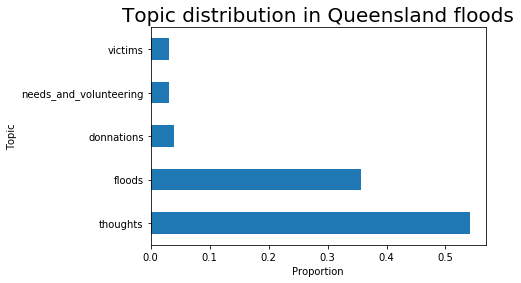

In [21]:
pd.Series(topic_preds).value_counts(normalize=True).plot.barh()
plt.title('Topic distribution in Queensland floods', fontsize=20)
plt.xlabel('Proportion')
plt.ylabel('Topic')
plt.show()

Given the data distribution we can now focus on particular topic of interres. For example we want to see what documents are mentionning victims:

In [22]:
classified_queensland_data = queensland_data.assign(topic=topic_preds)
classified_queensland_data.loc[classified_queensland_data['topic'] == 'victims']

,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,topic
34,294609615847571456,Queensland floods as cyclone sweeps past http:...,Outsiders,Other Useful Information,Related and informative,victims
207,295409335432007682,Queensland braces for flooding: The Australian...,Media,Caution and advice,Related and informative,victims
208,295409385772044288,Queensland braces for flooding: The Australian...,Outsiders,Caution and advice,Related and informative,victims
216,295412791509151744,http://t.co/DmDgLZRs Australian state of Queen...,Media,Infrastructure and utilities,Related - but not informative,victims
252,295431238062317568,Though pics have shown the banks have been bre...,Eyewitness,Other Useful Information,Related and informative,victims
348,295480454025465856,@craiglowndes888 So you're missing out on the...,Outsiders,Other Useful Information,Related - but not informative,victims
368,295491501822197760,http://t.co/uwJfTLgB Launch me personally from...,Not labeled,Not labeled,Not related,victims
383,295500481822875648,Start to worry when my backyard start to flash...,Eyewitness,Caution and advice,Related and informative,victims
413,295525060477870081,BBC News - Australian state of Queensland brac...,Media,Other Useful Information,Related and informative,victims
418,295530815054548993,"@jordyemmaxx yep, there pretty close. I need ...",Eyewitness,Affected individuals,Related and informative,victims
